In [15]:
%matplotlib inline 
# 画图
import random 
# 导入随机数模块
import torch 
# 导入PyTorch库
from d2l import torch as d2l 
# 公用库d2l

In [16]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w))) # normal(均值，标准差，可选的输出张量)
    y = torch.matmul(X, w) + b # matmul计算矩阵的乘法
    y += torch.normal(0, 0.01, y.shape) #加噪声
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4]) # 根据数据创建tensor（数组）
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [17]:
print('features:', features[0],'\nlabel:', labels[0])
# 输出第一层特征和第一层标签

features: tensor([-1.5482,  0.1206]) 
label: tensor([0.6970])


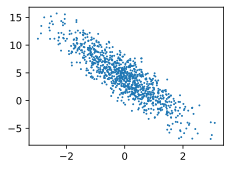

In [18]:
d2l.set_figsize()
# 设置图表大小
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);
# 绘制散点图，横坐标features，纵坐标labels，1表示完全不透明

In [19]:
def data_iter(batch_size, features, labels):
    # 输入批量大小、特征矩阵和标签向量
    num_examples = len(features) # 矩阵长度
    indices = list(range(num_examples)) # 长度为num_examples的list列表
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices) # 随机打乱indices列表中的元素顺序
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        # 将索引数组(indices)分成多个大小为batch_size的批次，并将每个批次转换为一个张量(tensor)
        yield features[batch_indices], labels[batch_indices] # 以批次数量为参数来生成对应的特征和标签

In [20]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    # 循环会对数据集进行迭代，每次返回一个batch_size大小的数据元组，其中包含特征和标签数据
    print(X, '\n', y)
    break

tensor([[-0.0428, -1.1259],
        [-1.1197, -0.3421],
        [-1.0207,  0.5477],
        [-1.5482,  0.1206],
        [ 2.0257, -0.4122],
        [ 0.2644,  1.4028],
        [ 1.3728, -0.6764],
        [-0.1220, -0.6262],
        [-0.7046, -1.0988],
        [-0.5395, -0.1161]]) 
 tensor([[ 7.9257],
        [ 3.1274],
        [ 0.2882],
        [ 0.6970],
        [ 9.6553],
        [-0.0598],
        [ 9.2453],
        [ 6.0888],
        [ 6.5244],
        [ 3.5279]])


In [21]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
# 生成服从均值为0，标准差为0.01的正态分布随机数的函数，生成的随机数是一个2行1列的张量，并且这个张量需要进行梯度计算
b = torch.zeros(1, requires_grad=True)
# 进行梯度计算

In [22]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [23]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [24]:
def sgd(params, lr, batch_size):  #@save
    # 输入模型参数集合、学习速率和批量大小
    """小批量随机梯度下降"""
    with torch.no_grad(): # 上下文管理器，在这个上下文中，所有操作都不会被追踪以用于求导
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_() # 将参数param的梯度grad清零

In [25]:
lr = 0.03 # 学习率
num_epochs = 3 # 迭代周期个数
net = linreg # 线性回归
loss = squared_loss # 平方损失

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward() # 对一个张量l中的所有元素求和，并对求和结果进行反向传播，即计算梯度
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad(): # 上下文管理器，在这个上下文中，所有操作都不会被追踪以用于求导
        train_l = loss(net(features, w, b), labels) # 计算损失
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.030195
epoch 2, loss 0.000105
epoch 3, loss 0.000052


In [26]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0001,  0.0003], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0003], grad_fn=<RsubBackward1>)
